## Transfer Learning
- Wifi y LTE
- pytorch


In [ ]:
#Listo las carpetas que contiene el dataset
!ls '/home/student1/notebook/dataset/teleco_signal/'

El diagrama ha sido generado como 'custom_network_architecture.png'


In [1]:
#Verifico la capacidad de GPU
!nvidia-smi

Sun Nov 24 16:33:36 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.01             Driver Version: 537.70       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4050 ...    On  | 00000000:01:00.0 Off |                  N/A |
| N/A   36C    P8               1W /  85W |   5876MiB /  6141MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
#Librerias a importar
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, models, transforms
import time
import copy
from torchviz import make_dot

Carga de las imágenes para entrenamiento

La normalizacion de las imágenes utiliza datos de Imagenet [0.485, 0.456, 0.406],                       [0.229, 0.224, 0.225]

Para val se añadio data augmentation, al tener pocas imagenes.

In [4]:
# Cargar las imagenes - datset

train_dataset = torchvision.datasets.ImageFolder('/home/aloha/Lun9ntbk/imagenes_vehiculos/train',
                                                transform=transforms.Compose([
                                                    transforms.RandomResizedCrop(224),
                                                    transforms. ToTensor(),
                                                    transforms.Normalize([0.485, 0.456, 0.406],
                                                                         [0.229, 0.224, 0.225])  # De imagenet
                                                    
                                                ]))
val_dataset = torchvision.datasets.ImageFolder('/home/aloha/Lun9ntbk/imagenes_vehiculos/val',
                                                  transform=transforms.Compose([
                                                  transforms.RandomRotation(10), 
                                                  transforms.RandomHorizontalFlip(),
                                                  transforms.Resize(256),  
                                                  transforms.CenterCrop(224),
                                                    transforms.ToTensor(),
                                                    transforms.Normalize([0.485, 0.456, 0.406],
                                                                         [0.229, 0.224, 0.225])
                                                    
                                                ]))

test_dataset = torchvision.datasets.ImageFolder('/home/aloha/Lun9ntbk/imagenes_vehiculos/test',
                                              transform=transforms.Compose([
                                                    transforms.Resize(256),
                                                    transforms.CenterCrop(224),
                                                    transforms. ToTensor(),
                                                    transforms.Normalize([0.485, 0.456, 0.406],
                                                                         [0.229, 0.224, 0.225])
                                                    
                                                ]))

print(train_dataset)
print(val_dataset)
print(test_dataset)

Dataset ImageFolder
    Number of datapoints: 1800
    Root location: /home/aloha/Lun9ntbk/imagenes_vehiculos/train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
Dataset ImageFolder
    Number of datapoints: 300
    Root location: /home/aloha/Lun9ntbk/imagenes_vehiculos/val
    StandardTransform
Transform: Compose(
               RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
               RandomHorizontalFlip(p=0.5)
               Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
Dataset ImageFolder
    Number of datapoints: 3

Se prepara los "loader" para train, val y test. Se utilizara un batch_size = 32


In [5]:
# imprimo un resumen de los datos
print('Train:', len(train_dataset))

Train: 1800


In [16]:
import os
from torch.utils.data.sampler import SubsetRandomSampler # type: ignore

batch_size = 4
learning_rate = 0.001
num_epocas = 1
step_log = 100
num_workers = os.cpu_count()

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                          batch_size = batch_size, num_workers=num_workers,
                                          shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                         batch_size = batch_size, num_workers=num_workers,
                                         shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                         batch_size = batch_size, num_workers=num_workers,
                                         shuffle=True)

class_names = train_dataset.classes
print(f"Usando {num_workers} workers para cargar datos.")

Usando 16 workers para cargar datos.


Se visualiza 4 imágenes de un batch tomados de train_loader, se añade los datos de normalizacion para la correcta visualizacion de las imágenes

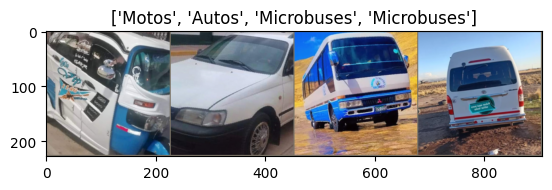

In [17]:
def imshow(inp, title = None):
  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  plt.imshow(inp)
  
  if title is not None:
    plt.title(title)
  plt.pause(0.001)
  
inputs, classes = next(iter(val_loader))
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

GPU para el enternamiento, verifico que se utilize CUDA
0-> para el primer gpu
1-> para seleccionar el segundo GPU en caso se tuviera

In [18]:
torch.cuda.set_device(0) 
device = ('cuda' if torch.cuda.is_available() else 'cpu')

print("Se entrenara con:", device)

Se entrenara con: cuda


Arquitectura de la red

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchviz import make_dot

# Definición de la arquitectura personalizada
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 256, kernel_size=3)
        self.bn1 = nn.BatchNorm2d(256)
        self.conv3 = nn.Conv2d(256, 512, kernel_size=3)
        self.fc1 = nn.Linear(512 * 26 * 26, 50)
        self.fc2 = nn.Linear(50, 3)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.bn1(self.conv2(x))), 2)
        x = F.max_pool2d(F.relu(self.conv3(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)

    def num_flat_features(self, x):
        size = x.size()[1:]  # All dimensions except batch
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

# Detectar dispositivo (CPU o GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Instanciar el modelo y moverlo al dispositivo
network = Network().to(device)

# Crear un tensor de entrada (batch size=1, canales=3, altura=224, ancho=224) y moverlo al dispositivo
x = torch.randn(1, 3, 224, 224, device=device)

# Generar el gráfico pasando el tensor por el modelo
output = network(x)  # Asegúrate de que tanto el modelo como el tensor estén en el mismo dispositivo
dot = make_dot(output, params=dict(network.named_parameters()))

# Guardar el gráfico como PNG
dot.render("custom_network_architecture", format="png")

print("El diagrama ha sido generado como 'custom_network_architecture2.png'")


El diagrama ha sido generado como 'custom_network_architecture2.png'


Función de entrenamiento para train y val

Se añade comentarios tomados de la documentación y foros explicando el proceso y parámetros utilizados

In [ ]:
def train_model(model, criterio, optimizer, scheduler, num_epochs):  
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_acc_train = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs-1))
        print('-' * 25)
    
        # Train model
        scheduler.step()
        model.train()
    
        running_loss = 0.0
        running_corrects = 0.0
    
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
        
            optimizer.zero_grad()
        
            outputs = model(inputs)
            
            # Aplicar log_softmax para usar NLLLoss
            log_probs = F.log_softmax(outputs, dim=1)
            
            # Calcular la pérdida usando log_probs
            loss = criterio(log_probs, labels)
        
            loss.backward()
            optimizer.step()
        
            # Calcular predicciones
            _, preds = torch.max(log_probs, 1)
        
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        
        epoch_loss_train = running_loss / len(train_dataset)
        epoch_acc_train = running_corrects.double() / len(train_dataset)
    
        print('Train Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss_train, epoch_acc_train))
        if epoch_acc_train > best_acc_train:
              best_acc_train = epoch_acc_train
        
        # Validation 
        model.eval()
        running_loss = 0.0
        running_corrects = 0.0
    
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
        
            with torch.set_grad_enabled(False):
                outputs = model(inputs)
                
                # Aplicar log_softmax para validación
                log_probs = F.log_softmax(outputs, dim=1)
                
                # Calcular la pérdida
                loss = criterio(log_probs, labels)
                
                # Calcular predicciones
                _, preds = torch.max(log_probs, 1)
            
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
        epoch_loss_val = running_loss / len(val_dataset)
        epoch_acc_val = running_corrects.double() / len(val_dataset)
                   
        print('Val Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss_val, epoch_acc_val))
                      
        if epoch_acc_val > best_acc:
              best_acc = epoch_acc_val
              best_model_wts = copy.deepcopy(model.state_dict())
              torch.save(best_model_wts, 'CP_nllloss.pth')  # Cambia el nombre para distinguirlo
              
    time_elapsed = time.time() - since
    print("####################################################")
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed//60, time_elapsed % 60))
    print('Best train accuracy: {:.4f}'.format(best_acc_train))
    print('Best val accuracy: {:.4f}'.format(best_acc))
    model.load_state_dict(best_model_wts)
    return model



Funcion test

In [13]:
def test_model(model):
    model.eval()
    running_loss = 0.0
    running_corrects = 0.0
    
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            
            # Aplicar log_softmax para usar NLLLoss
            log_probs = F.log_softmax(outputs, dim=1)
            
            # Calcular la pérdida usando log_probs
            loss = criterion(log_probs, labels)
            
            # Calcular predicciones
            _, preds = torch.max(log_probs, 1)
            
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
            
    epoch_loss = running_loss / len(test_dataset)
    epoch_acc = running_corrects.double() / len(test_dataset)
        
    print('Test Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))
    return model


Visualizar el resultado, se utiliza imagenes en test

In [14]:
def visualize_model(model, num_images):
    was_training = model.training
    
    model.eval()
    images_so_far = 0
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            
            # Aplicar log_softmax
            log_probs = F.log_softmax(outputs, dim=1)
            
            # Obtener predicciones
            _, preds = torch.max(log_probs, 1)
                    
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images, 1, images_so_far)
                
                ax.axis('off')
                ax.set_title('Predicted: {} (Clase: {})'.format(
                    class_names[preds[j]], class_names[labels[j]]))
                                
                imshow(inputs.cpu().data[j])
                
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return           
        
        model.train(mode=was_training)


torch.hub.list(github, force_reload=False, skip_validation=False)###Entrenamiento 1

Función de pérdida: CrossEntropyLoss

Optimizador: stochastic gradient descent SGD

In [15]:
import torch
import torch.nn as nn
from torchvision.models import vgg16, VGG16_Weights

# Cargar VGG16 con pesos preentrenados
weights = VGG16_Weights.IMAGENET1K_V1
model_vgg16 = vgg16(weights=weights)
model_vgg16.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [16]:
# Arquitectura del modeloM
model_vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [17]:
num_ft = model_vgg16.classifier[-1].in_features
model_vgg16.classifier[-1] = nn.Linear(num_ft, 3)

In [18]:
# Modelo a GPU
model_vgg16 = model_vgg16.to(device)

In [19]:
# FUncion de perdidad, optimizador, LR
criterion = nn.NLLLoss()
optimizer = torch.optim.SGD(model_vgg16.parameters(), lr=0.001, momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

Pruebo el entrenamiento con los datos de test

In [20]:
model_vgg16 = train_model(model_vgg16, criterion, optimizer, scheduler, num_epochs=num_epocas)

Epoch 0/19
-------------------------


/home/aloha/miniconda3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


Train Loss: 0.5141 Acc: 0.8017
Val Loss: 0.7474 Acc: 0.7633
Epoch 1/19
-------------------------
Train Loss: 0.2649 Acc: 0.8983
Val Loss: 0.1294 Acc: 0.9400
Epoch 2/19
-------------------------
Train Loss: 0.1870 Acc: 0.9322
Val Loss: 0.0588 Acc: 0.9833
Epoch 3/19
-------------------------
Train Loss: 0.1735 Acc: 0.9339
Val Loss: 0.1627 Acc: 0.9467
Epoch 4/19
-------------------------
Train Loss: 0.1454 Acc: 0.9489
Val Loss: 0.0603 Acc: 0.9833
Epoch 5/19
-------------------------
Train Loss: 0.1297 Acc: 0.9561
Val Loss: 0.0915 Acc: 0.9767
Epoch 6/19
-------------------------
Train Loss: 0.0711 Acc: 0.9739
Val Loss: 0.0517 Acc: 0.9800
Epoch 7/19
-------------------------
Train Loss: 0.0577 Acc: 0.9794
Val Loss: 0.0766 Acc: 0.9700
Epoch 8/19
-------------------------
Train Loss: 0.0572 Acc: 0.9750
Val Loss: 0.0662 Acc: 0.9767
Epoch 9/19
-------------------------
Train Loss: 0.0472 Acc: 0.9817
Val Loss: 0.0534 Acc: 0.9833
Epoch 10/19
-------------------------
Train Loss: 0.0472 Acc: 0.980

Visualización de resultados en test

In [22]:
model_vgg16_test = test_model(model_vgg16)

Test Loss: 0.1163 Acc: 0.9800


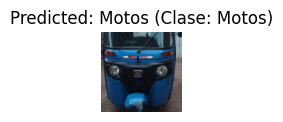

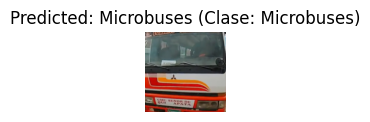

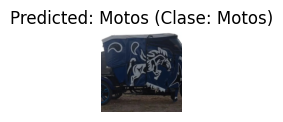

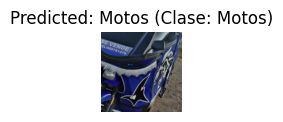

In [24]:
visualize_model(model=model_vgg16, num_images = 4)